## Market Data Dashboard

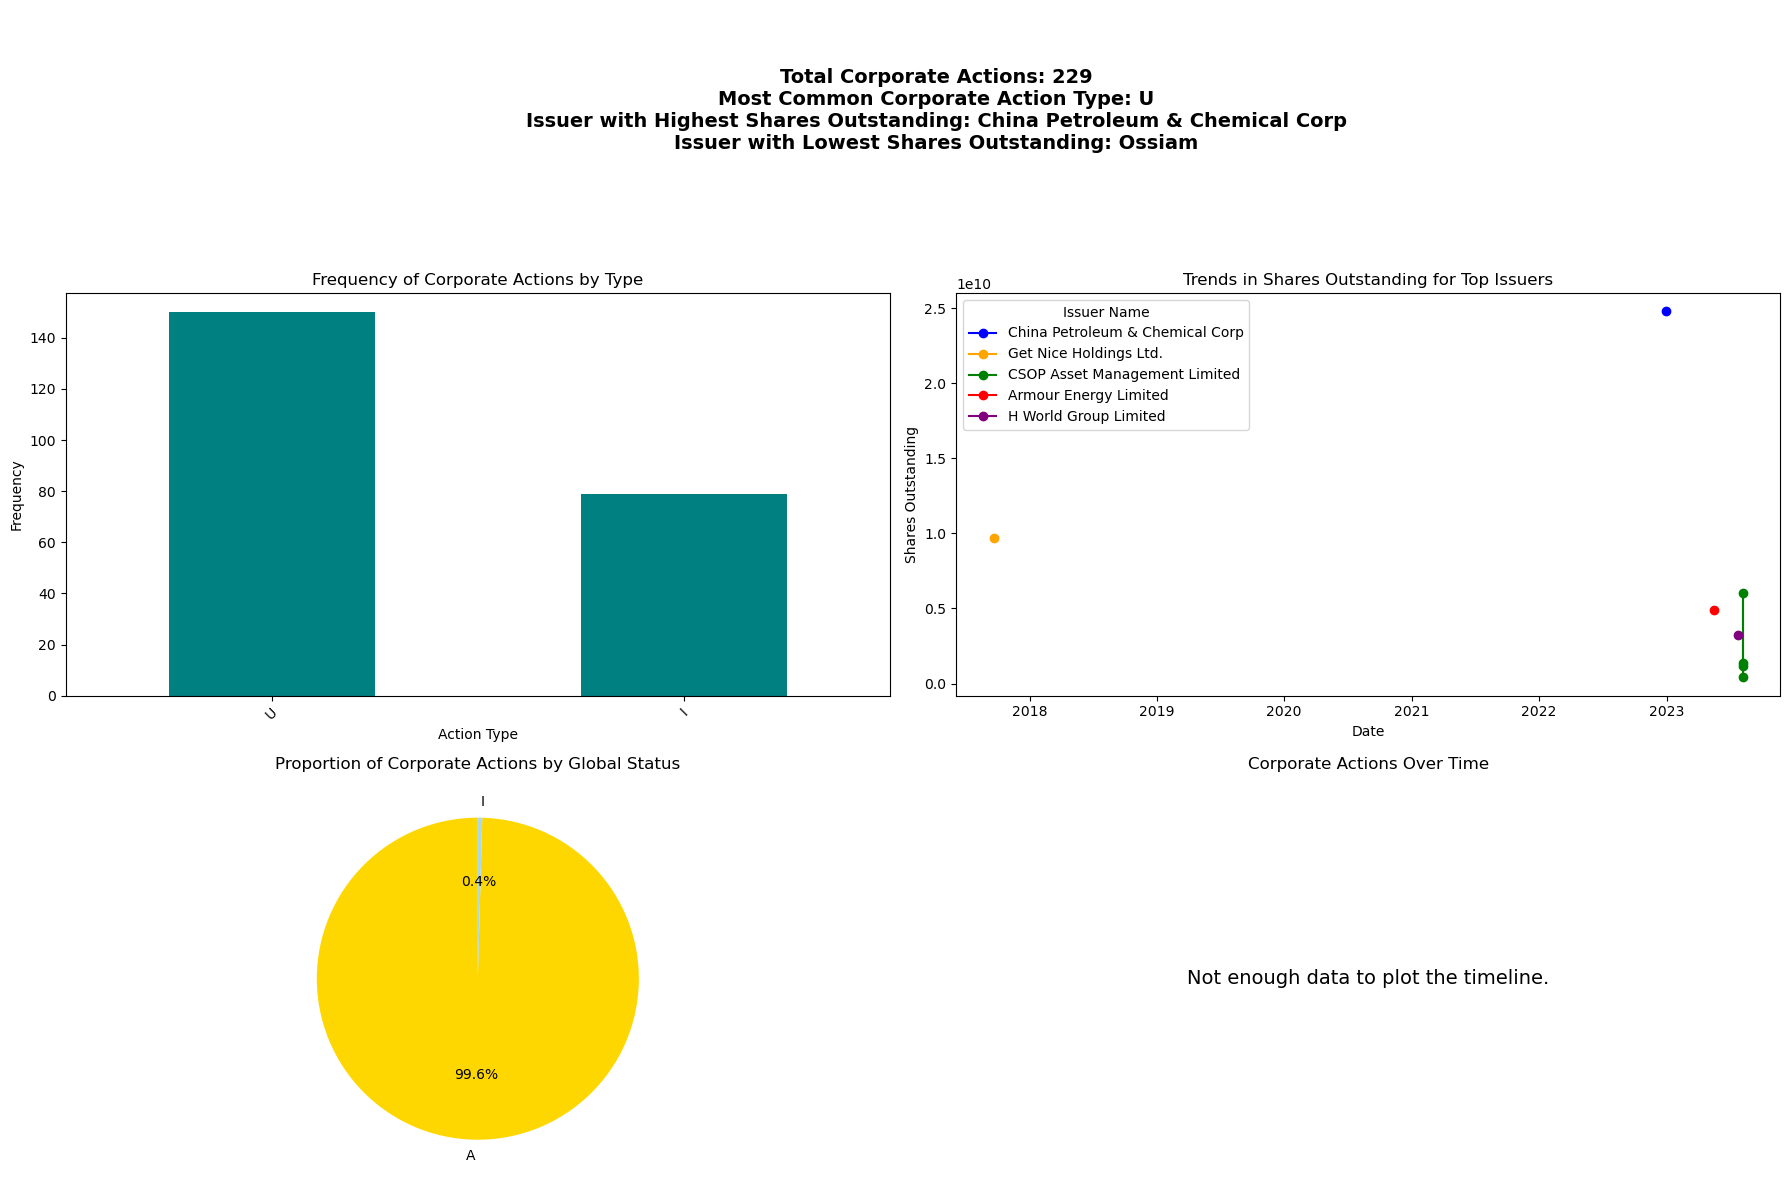

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

file_path = r'C:\Users\Alansi Gamil\Desktop\My project\Corporate Actions Market Data Sweden\Corporate Actions Market Data Sweden.xlsx'

try:
    excel_data = pd.ExcelFile(file_path)
    data = pd.read_excel(file_path, sheet_name='Sheet1')

    data.columns = data.iloc[1]  
    data = data[2:]  
    data.reset_index(drop=True, inplace=True)

    # Select relevant columns
    selected_columns = [
        "IssuerName", "SharesOutstanding", "SharesOutstandingDT",
        "GlobalStatusCD", "ListCreateDT", "LstChangeDT", "LstActionCD",
        "SecID", "Voting"
    ]
    cleaned_data = data[selected_columns]

    # Drop rows with missing values in essential columns
    cleaned_data = cleaned_data.dropna(subset=["IssuerName", "SharesOutstanding", "GlobalStatusCD"])

    # Convert columns to appropriate data types
    cleaned_data["SharesOutstanding"] = pd.to_numeric(cleaned_data["SharesOutstanding"], errors='coerce')
    cleaned_data["SharesOutstandingDT"] = pd.to_datetime(cleaned_data["SharesOutstandingDT"], errors='coerce')
    cleaned_data["ListCreateDT"] = pd.to_datetime(cleaned_data["ListCreateDT"], errors='coerce')
    cleaned_data["LstChangeDT"] = pd.to_datetime(cleaned_data["LstChangeDT"], errors='coerce')

    # Dashboard creation
    fig = plt.figure(figsize=(18, 12))
    grid = GridSpec(3, 2, figure=fig, height_ratios=[1, 2, 2])

    # Metrics Summary
    total_actions = len(cleaned_data)
    most_common_action = cleaned_data["LstActionCD"].value_counts().idxmax() if "LstActionCD" in cleaned_data else "N/A"
    highest_shares_issuer = cleaned_data.loc[cleaned_data["SharesOutstanding"].idxmax(), "IssuerName"]
    lowest_shares_issuer = cleaned_data.loc[cleaned_data["SharesOutstanding"].idxmin(), "IssuerName"]

    # Summary text
    ax1 = fig.add_subplot(grid[0, :])
    ax1.axis('off')  # Hide axis for clean summary
    summary_text = f"""
    Total Corporate Actions: {total_actions}
    Most Common Corporate Action Type: {most_common_action}
    Issuer with Highest Shares Outstanding: {highest_shares_issuer}
    Issuer with Lowest Shares Outstanding: {lowest_shares_issuer}
    """
    ax1.text(0.5, 0.5, summary_text, fontsize=14, ha='center', va='center', fontweight='bold')

    # Bar Chart: Frequency of Corporate Actions by Type
    if "LstActionCD" in cleaned_data.columns:
        ax2 = fig.add_subplot(grid[1, 0])
        action_types = cleaned_data["LstActionCD"].value_counts()
        action_types.plot(kind="bar", ax=ax2, color="teal")
        ax2.set_title("Frequency of Corporate Actions by Type")
        ax2.set_xlabel("Action Type")
        ax2.set_ylabel("Frequency")
        ax2.tick_params(axis='x', rotation=45)

    # Line Graph: Trends in Shares Outstanding for Top Issuers
    top_issuers = cleaned_data.groupby("IssuerName")["SharesOutstanding"].sum().nlargest(5).index
    top_issuers_data = cleaned_data[cleaned_data["IssuerName"].isin(top_issuers)].sort_values("SharesOutstandingDT")
    ax3 = fig.add_subplot(grid[1, 1])
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    for i, issuer in enumerate(top_issuers):
        issuer_data = top_issuers_data[top_issuers_data["IssuerName"] == issuer]
        ax3.plot(issuer_data["SharesOutstandingDT"], issuer_data["SharesOutstanding"], marker="o", label=issuer, color=colors[i])
    ax3.set_title("Trends in Shares Outstanding for Top Issuers")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Shares Outstanding")
    ax3.legend(title="Issuer Name")

    # Pie Chart: Proportion of Corporate Actions by GlobalStatusCD
    ax4 = fig.add_subplot(grid[2, 0])
    status_group = cleaned_data["GlobalStatusCD"].value_counts()
    status_group.plot.pie(ax=ax4, autopct='%1.1f%%', startangle=90, colors=['gold', 'lightblue', 'lightgreen'])
    ax4.set_title("Proportion of Corporate Actions by Global Status")
    ax4.set_ylabel("")

    # Timeline Chart: Corporate Actions Over Time
    ax5 = fig.add_subplot(grid[2, 1])
    timeline_data = cleaned_data["LstChangeDT"].dt.to_period("M").value_counts().sort_index()
    if len(timeline_data) > 1:
        timeline_data.plot(kind="line", marker="o", ax=ax5, color="darkred")
        ax5.set_title("Corporate Actions Over Time")
        ax5.set_xlabel("Date")
        ax5.set_ylabel("Frequency")
    else:
        ax5.text(0.5, 0.5, "Not enough data to plot the timeline.", ha="center", va="center", fontsize=14)
        ax5.set_title("Corporate Actions Over Time")
        ax5.axis('off')  # Hide axis if no plot is generated

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("The file could not be found. Please check the file path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")
